# Visual Grounding<br>
Borghini Alessia (1834906), Di Valerio Federico (1835405)

**Visual grounding (VG)** is the task of locating the **instance** of a description in an image.
The description, also known as **query**, is a natural-language phrase.
For instance, given the query *"the man with a black shirt"*, the VG model returns the patch extracted from the original image that corresponds to such a subject. <br>
Visual grounding is a task useful for applications such as image captioning, visual question answering, and image retrieval.

## Setup environment


In [ ]:
! nvidia-smi

In [ ]:
# Mount Google Drive
# from google.colab import drive

# drive.mount("/content/drive") # force_remount=True

In [ ]:
import os

# PATH = "drive/MyDrive/Visual_Grounding/"
# os.chdir(PATH)

In [ ]:
# ! ls

In [ ]:
! pip install datasets

# ! pip install transformers
! pip install bbox-visualizer

# ! pip install modelscope[cv] -f https://modelscope.oss-cn-beijing.aliyuncs.com/releases/repo.html
# ! pip install fairseq
# ! pip install unicodedata2
# ! pip install decord>=0.6.0
# ! pip install zhconv
# ! pip install rapidfuzz

! sudo pip install timm

!pip install einops
!pip install ftfy
!pip install captum

In [ ]:
import sys
import os
import os.path as osp
import json
import pickle
import time
import itertools
import skimage.io as io
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

from pprint import pprint
import numpy as np
# from external import mask

# from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
import torch.nn as nn

from PIL import Image
import requests
import bbox_visualizer as bbv
# from transformers import DetrFeatureExtractor, DetrForObjectDetection
import requests

from datasets import load_dataset

import ast
from tqdm import tqdm
import requests

import numpy as np

# from transformers import pipeline
# from transformers import CLIPProcessor, CLIPModel

from wordcloud import WordCloud, STOPWORDS

# import CLIP.clip as clip
import cv2
from google.colab.patches import cv2_imshow

from captum.attr import visualization

In [ ]:
device = "cuda"

## Dataset


In [ ]:
dataset_name = "refcoco" #"refcocoplus" "refcoco"

In [ ]:
dataset = load_dataset("jxu124/"+dataset_name)
dataset

Download images from urls

In [ ]:
dataset_split = "testB"
dataset_path = dataset_name+"/"+dataset_split+"/"

In [ ]:
dataset[dataset_split][0]

In [ ]:
# j = 0

# for i in tqdm(range(len(dataset[dataset_split]))):
#     im = dataset[dataset_split][i]
#     if im["file_name"] == "COCO_train2014_000000034739_1160871.jpg":
#         # image_url = json.loads(im["raw_image_info"])["flickr_url"]
#         # img = requests.get(image_url).content
#         # with open("winnie.jpg", 'wb') as handler:
#         #     handler.write(img)
#         # caption = im["captions"]
#         true_box = im["bbox"]

Save images in Drive

In [ ]:
os.mkdir(dataset_name)
os.chdir(dataset_name)
os.mkdir(dataset_split)
%cd ..
!ls

In [ ]:
j = 0
num_images = 100

for i in tqdm(range(len(dataset[dataset_split]))):
    im = dataset[dataset_split][i]
    image_url = json.loads(im["raw_image_info"])["flickr_url"]

    if i == num_images:
        break

    if os.path.exists(dataset_path+im["file_name"]):
        # print("continue")
        continue

    try:
        img_data = requests.get(image_url).content
        with open(dataset_path+im["file_name"], 'wb') as handler:
            handler.write(img_data)
    except:
        # print(image_url)
        j += 1


Check if the image path in the dataset exists

In [ ]:
# k = 0
# j = 0

# for i in tqdm(range(len(dataset["train"]))):
#     path = "train_/" + dataset["train"][i]["file_name"]
#     # print(path)
#     # break
#     try:
#         im = Image.open(path)
#         k += 1
#     except:
#         print(path)

#         j += 1
#     # if os.path.exists(path):
#     #     k+=1
#     #     # print(i,path)

#     # else:
#     #     j+=1

# print(k, j)

## Baseline model
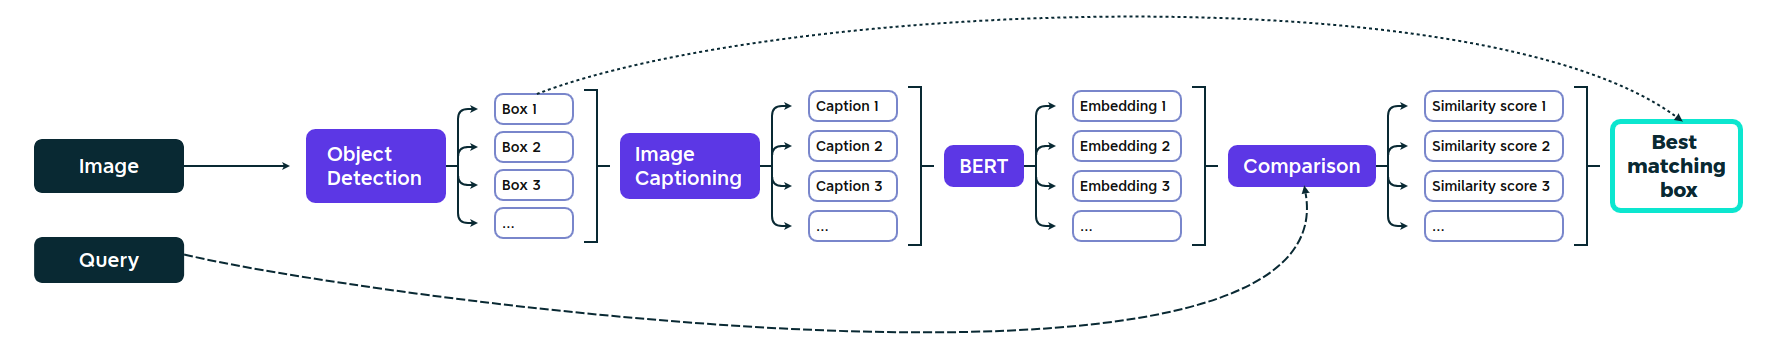

## Object Detection


### Detr model

In [ ]:
# uncomment to run (incompatible with OFA model)
# !pip install transformers
# from transformers import DetrImageProcessor, DetrForObjectDetection


# feature_extractor = DetrImageProcessor.from_pretrained('facebook/detr-resnet-101-dc5')
# model = DetrForObjectDetection.from_pretrained('facebook/detr-resnet-101-dc5').to(device)

# threshold = 0.9

Object detection workflow

In [ ]:
# j = 0

# for i,elem in tqdm(enumerate(dataset["train"])):

#     if i != 789:
#         continue
#     path = "train/" + elem["file_name"]

#     try:
#         image = Image.open(path)
#         image = image.convert('RGB')
#     except:
#         j+=1
#         continue

#     true_box = elem["bbox"]

#     with torch.autocast(device_type="cuda"):
#         inputs = feature_extractor(images=image, return_tensors="pt").to(device)
#         outputs = model(**inputs)

#     # model predicts bounding boxes and corresponding classes
#     logits = outputs.logits
#     bboxes = outputs.pred_boxes

#     # let's only keep detections with score > 0.9
#     target_sizes = torch.tensor([image.size[::-1]])
#     results = feature_extractor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

#     img = np.array(image)
#     cropped_imgs = []
#     for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
#         box = [int(i) for i in box.tolist()]

#         img = bbv.draw_rectangle(img, box, thickness = 2, bbox_color = [0,0,0])
#         img = bbv.add_label(img, model.config.id2label[label.item()], box,top=True)
#         cropped_imgs.append(image.crop(box))

#     img1 = Image.fromarray(img)
#     break

Write boxes coordinates on json file

In [ ]:
# j = 0
# data = {}

# for count,elem in enumerate(tqdm(dataset["testB"])):

#     path = "refcoco/testB/" + elem["file_name"]

#     if path in data:
#         continue

#     try:
#         image = Image.open(path)
#         image = image.convert('RGB')
#     except:
#         j+=1
#         continue

#     data[path] = {"boxes": [],
#                     "true_box": [],
#                     "captions": [],
#                     "query": []}

#     data[path]["true_box"] = elem["bbox"]
#     data[path]["query"] = elem["captions"]

#     with torch.autocast(device_type=device):
#         inputs = feature_extractor(images=image, return_tensors="pt").to(device)
#         outputs = model(**inputs)

#     # model predicts bounding boxes and corresponding classes
#     logits = outputs.logits
#     bboxes = outputs.pred_boxes

#     # let's only keep detections with score > 0.9
#     target_sizes = torch.tensor([image.size[::-1]])
#     results = feature_extractor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=threshold)[0]
#     data[path]["boxes"] = results["boxes"].tolist()


#     if count % 100 == 0 or count != 0:
#         with open("refcoco_testB_nocaptions.json", "w") as f:
#             json.dump(data, f)

#     if j != 0:
#         break

# print("non trovate", j)

### Yolo

In [ ]:
! pip install -U ultralytics

#### Yolov8

In [ ]:
sample_image = "/content/refcoco/testB/COCO_train2014_000000552549_5.jpg"

In [ ]:
from ultralytics import YOLO

# Download pre-trained model
model = YOLO("yolov8x.pt")

# Usage example
im1 = Image.open(sample_image)
results = model.predict(source=im1, save=True)

In [ ]:
# Yolo detected classes
from_cls_to_names = results[0].names
from_cls_to_names

Yolo v8 workflow

In [ ]:
od_name = "yolov8"

file_path = dataset_name + "_" + dataset_split + "_" + od_name + "_nocaptions.json"
file_path

In [ ]:
j = 0

with open(file_path, "w") as f:
    data = {}

    for elem in tqdm(dataset[dataset_split]):

        path = dataset_path + elem["file_name"]

        if path in data:
            continue

        try:
            Image.open(path)
            # image = image.convert('RGB')
        except:
            j+=1
            continue

        data[path] = {"boxes": [],
                      "cls": [],
                        "true_box": [],
                      "query": [],
                        "captions": [],}

        data[path]["true_box"] = elem["bbox"]
        data[path]["query"] = elem["captions"]

        with torch.autocast(device_type="cuda"):
            results = model.predict(path, save=False, verbose=False)

        boxes = []
        classes = []
        for elem,cls in zip(results[0].boxes.xyxy, results[0].boxes.cls):
            boxes.append(elem[:4].tolist())
            classes.append(from_cls_to_names[int(cls)])

        data[path]["boxes"] = boxes
        data[path]["cls"] = classes

        if j!= 0:
            break

    json.dump(data, f)


print("non trovate", j)

#### Yolov5


In [ ]:
# Example of usage
# Model
model = YOLO("yolov5x.pt")

# Usage example
im1 = Image.open(sample_image)
results = model.predict(source=im1, save=True)
results

Yolo v5 workflow

In [ ]:
od_name = "yolov5"
file_path = dataset_name + "_" + dataset_split + "_" + od_name + "_nocaptions.json"

In [ ]:
j = 0
with open(file_path, "w") as f:
    data = {}

    for elem in tqdm(dataset[dataset_split]):

        path = dataset_path + elem["file_name"]

        if path in data:
            # if data[path]["boxes"] != []:
            continue

        try:
            Image.open(path)
            # image = image.convert('RGB')
        except:
            j+=1
            continue

        data[path] = {"boxes": [],
                        "true_box": [],
                      "query": [],
                        "captions": []}

        data[path]["true_box"] = elem["bbox"]
        data[path]["query"] = elem["captions"]

        with torch.autocast(device_type="cuda"):
            results = model(path)

        boxes = []
        for elem in results[0].boxes.xyxy:
            boxes.extend(elem[:3].tolist())

        data[path]["boxes"] = boxes

        if j!= 0:
            break
    json.dump(data, f)

print("non trovate", j)

## Analysis

### Visual Grounding Upper Bound

Intersection over Union (IoU) metric

In [ ]:
def bb_intersection_over_union(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

Computation of IoU and accuracy upper bounds given object detected by models

In [ ]:
file_path = "refcoco_testB_yolov8_nocaptions.json"

In [ ]:
scores = []
with open(file_path) as f:
    f = f.read()
    d = json.loads(f)

    for i,(k,v) in enumerate(tqdm(d.items())):

        image = Image.open(k)
        boxes = v["boxes"]
        true_box = v["true_box"]

        img = np.array(image)
        cropped_imgs = []
        img_size = img.shape

        max_score = 0.0
        for box in boxes:

            box = [int(i) for i in box]

            curr_score = bb_intersection_over_union(box, true_box)
            if curr_score > max_score:
                max_score = curr_score

        scores.append(max_score)

np.mean(scores)

In [ ]:
ones = [1]*len(scores)
zeros = [0]*len(scores)
acc = np.where(np.array(scores)>0.5, ones, zeros)
np.mean(acc)

Plot histogram of IoUs

In [ ]:
plt.hist(scores)

# plt.savefig("plot.png")

### WordClouds

In [ ]:
# Set stopwords to remove
stopwords = set(STOPWORDS)

In [ ]:
# Collect queries and captions of the images

queries = []
captions = []
# file_path = "refcocoplus_testB_nocaptions.json"
d = {}
with open(file_path) as f:
    f = f.read()
    d = json.loads(f)

for k,elem in d.items():
    queries.extend(elem["query"])
    captions.extend(elem["captions"])

Generate WordCloud

In [ ]:
wordcloud = WordCloud(width = 1000, height = 800,
                background_color =None,
                mode="RGBA",
                colormap="PuOr_r",
                stopwords = stopwords,
                min_font_size = 10).generate(" ".join(queries))

plt.figure(figsize = (10, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.savefig("wordcloud_refcocoplus_testB")

## Image Captioning

### Blip model

In [ ]:
from transformers import pipeline

In [ ]:
pipe = pipeline("image-to-text", model="Salesforce/blip-image-captioning-large")

In [ ]:
pipe(Image.open(sample_image))

In [ ]:
# pipe(Image.open("/content/patch3.png"))

### ViT GPT2 model

In [ ]:
image_to_text = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")

In [ ]:
image_to_text(Image.open(sample_image))

In [ ]:
# image_to_text(Image.open("/content/patch3.png"))

### OFA model<br>
Requires a lot of time to complete, so we commented it

In [ ]:
# ! pip install modelscope[cv] -f https://modelscope.oss-cn-beijing.aliyuncs.com/releases/repo.html

In [ ]:
# ! pip install fairseq
# ! pip install unicodedata2
# ! pip install decord>=0.6.0
# ! pip install zhconv
# ! pip install rapidfuzz

In [ ]:
# from modelscope.pipelines import pipeline
# from modelscope.utils.constant import Tasks
# from modelscope.outputs import OutputKeys

# img_captioning = pipeline(Tasks.image_captioning,
#                           model='damo/ofa_image-caption_coco_large_en',
#                           model_revision='v1.0.1',
#                           device="cuda")

Code for restoring the interrupted workflow

In [ ]:
# d_pt1 = {}
# d_pt2 = {}
# new_d = {}

# with open("dataset2_pt1.json", "r") as f:
#     f = f.read()
#     d_pt1 = json.loads(f)

# with open("dataset2_pt2.json", "r") as f:
#     f = f.read()
#     d_pt2 = json.loads(f)

# for k in d_pt1.keys():
#     if d_pt1[k]["captions"] != []:
#         new_d[k] = d_pt1[k]
#     elif d_pt2[k]["captions"] != []:
#         new_d[k] = d_pt2[k]
#     else:
#         new_d[k] = d_pt1[k]

In [ ]:
# Amount of images already processed

# tot = 0
# for k,v in new_d.items():
#     if v["captions"] != []:
#         tot += 1

# print(tot)

In [ ]:
# Read dataset and counter

# j=0

# d2 = {}
# with open("dataset2.json", "r") as f:
#     f = f.read()
#     d2 = json.loads(f)
# with open("dataset.json", "r") as f:
#     f = f.read()
#     d = json.loads(f)
#     for i, (img,data) in enumerate(tqdm(d.items())):
#         print(d2[img]["captions"])
#         if d2[img]["captions"] != []:
#             j+=1

OFA Workflow

In [ ]:
# d2 = new_d
od_name = "yolov8x"
out_file_path = dataset_name + "_" + dataset_split + "_" + od_name + ".json"

In [ ]:
# i=0
# file_path = "refcoco_testB_yolov8_nocaptions.json"
# d2 = {}

# with open(file_path, "r") as f:
#     f = f.read()
#     d = json.loads(f)
#     d2 = d.copy()
#     # for i, (img,data) in enumerate(tqdm(d.items())):
#     for img,data in tqdm(d.items()):

#         if d2[img]["captions"] != []:
#             continue
#         i+=1
#         image = Image.open(img)
#         # image = np.array(image)
#         captions = []
#         for box in data["boxes"]:
#             box = [int(i) for i in box]
#             patch = image.crop(box) #.to(device)
#             # print(patch)
#             with torch.autocast(device_type=device):
#                 result = img_captioning(patch)
#             captions.append(result[OutputKeys.CAPTION][0])

#         d2[img]["captions"] = captions

#         # break
#         if i % 100 == 0 and i != 0:
#             print(i)
#             with open(out_file_path, "w") as f:
#                 json.dump(d2, f)

# with open(out_file_path, "w") as f:
#     json.dump(d2, f)

### Adding spatial context
Adding "on the left" or "on the right" to the obtained queries in order to give a space reference

In [ ]:
# def bb_intersection_over_union_normalized(boxA, boxB):
#     xA = max(boxA[0], boxB[0])
#     yA = max(boxA[1], boxB[1])
#     xB = min(boxA[2], boxB[2])
#     yB = min(boxA[3], boxB[3])

#     interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

#     boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)

#     boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

#     iou = interArea / float(boxBArea)

#     return iou

In [ ]:
# with open("dataset_test_query.json", "r") as f:
#     f = f.read()
#     d = json.loads(f)
#     d2 = d.copy()

#     for k,v in tqdm(d.items()):
#         # print(k)
#         img = Image.open(k)
#         img_size = img.size

#         tl_corner = [0,0]
#         br_corner = [img_size[0], img_size[1]]
#         central_point = [img_size[0]/2, img_size[1]/2]

#         tl_box = tl_corner + central_point
#         br_box = central_point + br_corner
#         tr_box = [img_size[0]/2, 0, img_size[0], img_size[1]/2]
#         bl_box = [0, img_size[1]/2, img_size[0]/2, img_size[1]]

#         boxes_ = [tl_box, br_box, tr_box, bl_box]
#         patch_boxes = v["boxes"]

#         for i,patch in enumerate(patch_boxes):
#             res = []
#             to_add = ""
#             for b in boxes_:
#                 res.append(bb_intersection_over_union_normalized(b, patch))

#             if res[0] + res[3] > 0.95:
#                 to_add += " on the left"
#             elif res[2] + res[1] > 0.95:
#                 to_add += " on the right"

#             img.crop(patch)

#             v["captions"][i] += to_add
#         # break

# with open("dataset_test_left_right.json", "w") as f:
#     json.dump(d2, f)

## Caption Embeddings

In [ ]:
# ! pip install sentence_transformers

In [ ]:
# from sentence_transformers import SentenceTransformer

# model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

# # cosine similarity
# cos = nn.CosineSimilarity(dim=0, eps=1e-6)

Caption embeddings + evaluation of IoU.<br>
We consider as the predicted box, the one with the caption having the higher cosine similarity score to the query.

In [ ]:
# ious = []
# cos_list = []

# with open(out_file_path, "r") as f:
#     f = f.read()
#     d = json.loads(f)

#     for counter,(k,v) in enumerate(tqdm(d.items())):
#         captions = v["captions"]
#         queries = v["query"]

#         true_box = v["true_box"]
#         boxes = v["boxes"]
#         num_captions = len(captions)

#         sentences = captions + queries
#         num_sentences = len(sentences)

#         embeddings = model.encode(sentences)

#         best_match = {}
#         for i in range(num_captions):
#             for j in range(num_captions, num_sentences):

#                 res = cos(torch.from_numpy(embeddings[i]),
#                           torch.from_numpy(embeddings[j]))

#                 if sentences[j] not in best_match:
#                     best_match[sentences[j]] = {"score": -1.0,
#                                             #    "sentence": "",
#                                                "box": [],
#                                                "true_box": true_box
#                                                }

#                 if best_match[sentences[j]]["score"] < res:
#                     best_match[sentences[j]]["score"] = res
#                     # best_match[sentence[j]]["sentence"] = sentences[i]
#                     best_match[sentences[j]]["box"] = boxes[i]

#         for _,val in best_match.items():
#             cos_list.append(val["score"])
#             iou = bb_intersection_over_union(val["box"], val["true_box"])
#             ious.append(iou)

#         # print(ious)

#         # if counter % 50 == 0 and counter != 0:
#         #     print(np.mean(ious))
#         #     print(np.mean(cos_list))
#         # break

# print(np.mean(ious))
# print(np.mean(cos_list))

Distribution of cosine similarity scores

In [ ]:
# plt.hist(cos_list)

Distribution of IoUs scores

In [ ]:
# plt.hist(ious)

In [ ]:
# scores = ious
# ones = [1]*len(scores)
# zeros = [0]*len(scores)
# acc = np.where(np.array(scores)>0.5, ones, zeros)
# np.mean(acc)

## CLIP
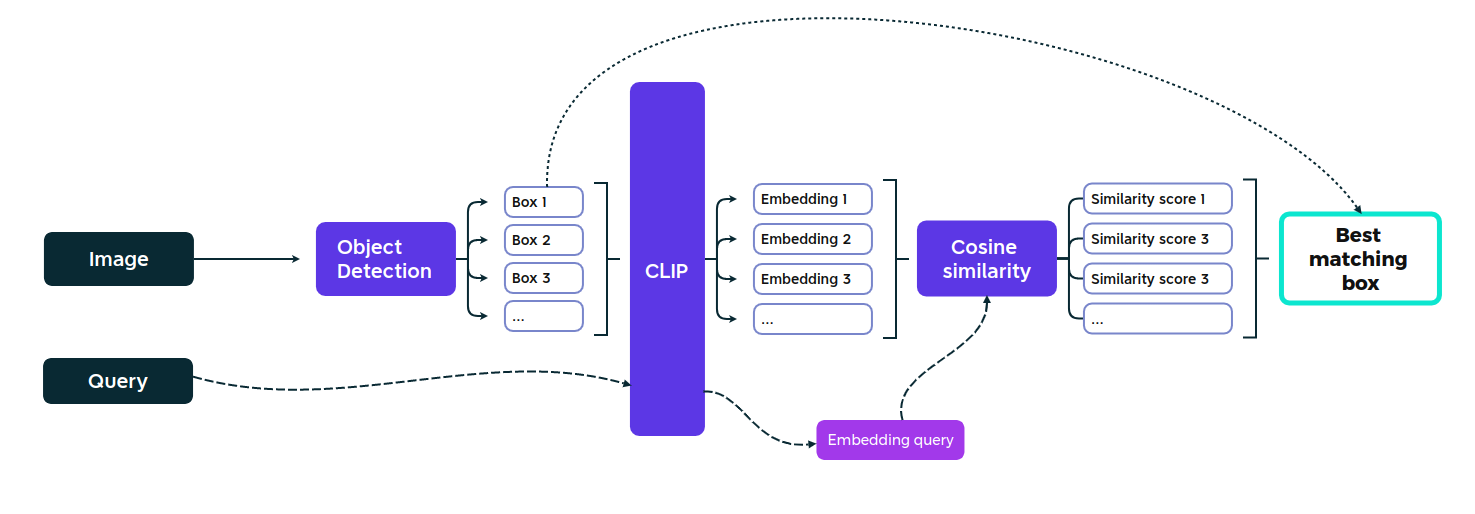



In [ ]:
def bb_intersection_over_union(boxA, boxB):

    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)

    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [ ]:
! pip install git+https://github.com/openai/CLIP.git --quiet

In [ ]:
import clip

clip_model, preprocess = clip.load("ViT-B/32", device="cuda")

cos = nn.CosineSimilarity(dim=-1, eps=1e-6)

In [ ]:
# to_write = {}
# with open("RefCOCO_testA_yolov5.json", "r") as f:
#     f = f.read()
#     to_write = json.loads(f)

# with open("dataset_test_query.json", "r") as g:
#     g = g.read()
#     d = json.loads(g)

#     for counter,(k,v) in enumerate(tqdm(d.items())):
#         print(v)
#         to_write[k]["query"] = v["query"]

In [ ]:
# with open("RefCOCO_testA_yolov5_query.json", "w") as f:
#     f = json.dump(to_write, f)

Example of usage with an image

In [ ]:
# j = 0
# ious = []
# cos_list = []

# img = Image.open("winnie.jpg").convert("RGB")

# image = img

# queries = caption
# print(queries)

# for query in queries:
#     best_res = 0.0
#     best_iou = 0.0
#     best_box = []

#     print(query)
#     tok_queries = clip.tokenize(query).to(device)

#     with torch.no_grad():
#         #calculate embeddings
#         with torch.autocast(device_type=device):
#             text_features = clip_model.encode_text(tok_queries).float()
#     # print(queries)

#     # boxes = v["boxes"]
#     # true_box = v["true_box"]
#     # print(boxes)
#     image_features = []

#     # print(boxes)
#     for box in boxes:
#         box = [int(i) for i in box[:4]]
#         patch = image.crop(box)
#         img = preprocess(patch).to(device).unsqueeze(0)
#         with torch.no_grad():
#             with torch.autocast(device_type=device):
#                 image_features = clip_model.encode_image(img).float()

#         print(image_features.shape)
#         print(text_features.shape)
#         image_features /= image_features.norm(dim=-1, keepdim=True)
#         text_features /= text_features.norm(dim=-1, keepdim=True)

#         res = cos(image_features, text_features)
#         # res2 = cos(text_features[j], image_features[i])
#         similarity = text_features.unsqueeze(0).cpu().numpy() @ image_features.cpu().numpy().T
#         sim = torch.nn.functional.cosine_similarity(text_features, image_features)
#         # print(queries[j], res)

#         if res > best_res:
#             best_res = res
#             best_iou = iou
#             best_box = box
#         iou = bb_intersection_over_union(box, true_box)
#         # iou2 = bb_intersection_over_union(true_box, boxes[i])

#         print(query)
#         print(similarity, sim, res, iou)

#     print("BEST",best_res, best_iou, best_box)

CLIP Workflow

In [ ]:
j = 0
ious = []
cos_list = []

with open(file_path) as f:
    f = f.read()
    d = json.loads(f)

    for counter,(k,v) in enumerate(tqdm(d.items())):
        try:
            image = Image.open(k)
            image = image.convert('RGB')
        except:
            j+=1
            continue

        queries = v["query"]
        tok_queries = clip.tokenize(queries).to(device)

        with torch.no_grad():
            with torch.autocast(device_type=device):
                text_features = clip_model.encode_text(tok_queries).float()

        boxes = v["boxes"]
        true_box = v["true_box"]
        image_features = []

        for box in boxes:
            patch = image.crop(box[:4])
            img = preprocess(patch).to(device).unsqueeze(0)
            with torch.no_grad():
                with torch.autocast(device_type=device):
                    if image_features == []:
                        image_features = clip_model.encode_image(img).float()
                    else:
                        image_features = torch.cat((image_features, clip_model.encode_image(img).float()), dim=0)


        if image_features == []:
            print(k)
            print(queries)
            continue

        best_match = {}
        for i in range(image_features.shape[0]):
            for j in range(text_features.shape[0]):

                res = cos(image_features[i], text_features[j])

                if queries[j] not in best_match:
                    best_match[queries[j]] = {"score": 0.0,
                                            #    "sentence": "",
                                               "box": [],
                                               "true_box": true_box
                                               }

                if best_match[queries[j]]["score"] < res:
                    best_match[queries[j]]["score"] = res
                    best_match[queries[j]]["box"] = boxes[i]

        for _,val in best_match.items():
            cos_list.append(val["score"])
            iou = bb_intersection_over_union(val["box"], val["true_box"])
            ious.append(iou)

        if counter % 50 == 0 and counter != 0:
            print(torch.mean(torch.tensor(cos_list)))
            print(np.mean(ious))

        # break

print(torch.mean(torch.tensor(cos_list)))
print(np.mean(ious))

In [ ]:
print(np.mean(ious))

In [ ]:
scores = torch.tensor(ious).cpu()
ones = [1]*len(scores)
zeros = [0]*len(scores)
print(scores)
acc = np.where(np.array(scores)>0.5, ones, zeros)
np.mean(acc)

Plot of IoUs distribution

In [ ]:
plt.hist(torch.tensor(scores).cpu())

## CLIP with Heatmaps
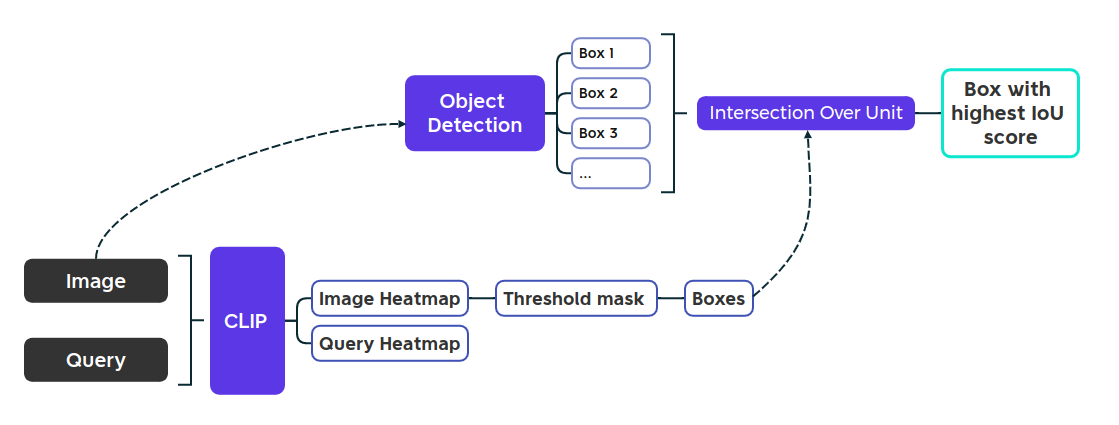

#### Install dependencies

In [ ]:
!git clone https://github.com/hila-chefer/Transformer-MM-Explainability

os.chdir(f'./Transformer-MM-Explainability')

In [ ]:
! pip install bbox_visualizer

In [ ]:
import CLIP.clip as clip
from CLIP.clip.simple_tokenizer import SimpleTokenizer as _Tokenizer

import bbox_visualizer as bbv

In [ ]:
start_layer =  -1
start_layer_text =  -1

#### Utilities

In [ ]:
def interpret(image, texts, model, device, start_layer=start_layer, start_layer_text=start_layer_text):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts)

    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)

    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())

    if start_layer == -1:
      start_layer = len(image_attn_blocks) - 1

    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(image_attn_blocks):
        if i < start_layer:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R = R + torch.bmm(cam, R)
    image_relevance = R[:, 0, 1:]


    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())

    if start_layer_text == -1:
      start_layer_text = len(text_attn_blocks) - 1

    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(text_attn_blocks):
        if i < start_layer_text:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R_text = R_text + torch.bmm(cam, R_text)
    text_relevance = R_text

    return text_relevance, image_relevance, logits_per_image

In [ ]:
def show_image_relevance(image_relevance, image, orig_image):

    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)

    return image_relevance

In [ ]:
_tokenizer = _Tokenizer()

def show_heatmap_on_text(text, text_encoding, R_text):
  CLS_idx = text_encoding.argmax(dim=-1)
  R_text = R_text[CLS_idx, 1:CLS_idx]
  text_scores = R_text / R_text.sum()
  text_scores = text_scores.flatten()
  print(text_scores)
  text_tokens=_tokenizer.encode(text)
  text_tokens_decoded=[_tokenizer.decode([a]) for a in text_tokens]
  vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,text_tokens_decoded,1)]
  visualization.visualize_text(vis_data_records)

In [ ]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [ ]:
clip.clip._MODELS = {
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
    "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
    "ViT-L/14": "https://openaipublic.azureedge.net/clip/models/b8cca3fd41ae0c99ba7e8951adf17d267cdb84cd88be6f7c2e0eca1737a03836/ViT-L-14.pt",
}

In [ ]:
def bb_intersection_over_box(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)

    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = interArea / float(boxAArea)

    return iou

In [ ]:
def bb_intersection_over_union(boxA, boxB):

    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)

    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [ ]:
def bb_intersection_over_union_normalized(boxA, boxB):

    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)

    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = interArea / float(boxBArea)

    return iou

In [ ]:
def convert_coordinates(processed_coordinate,
                        original_dim,
                        processed_dim):
    return int((processed_coordinate / processed_dim) * original_dim)

def convert_box(box,
                original_dim,
                processed_dim=[224,132]):

    if original_dim[0] > original_dim[1]:
        dim_y = (processed_dim[1]/original_dim[0])*original_dim[1]

        x1 = convert_coordinates(box[0], original_dim[0], processed_dim[0])
        y1 = convert_coordinates(box[1]-((processed_dim[1]-dim_y)//2), original_dim[1], processed_dim[1])-(processed_dim[1]-dim_y)
        x2 = convert_coordinates(box[2], original_dim[0], processed_dim[0])
        y2 = convert_coordinates(box[3]-((processed_dim[1]-dim_y)//2), original_dim[1], processed_dim[1])-(processed_dim[1]-dim_y)
    else:

        dim_x = (processed_dim[0]/original_dim[1])*original_dim[0]

        x1 = convert_coordinates(box[0]-((processed_dim[0]-dim_x)//2), original_dim[0], processed_dim[0])-(processed_dim[0]-dim_x)
        y1 = convert_coordinates(box[1], original_dim[1], processed_dim[1])
        x2 = convert_coordinates(box[2]-((processed_dim[0]-dim_x)//2), original_dim[0], processed_dim[0])-(processed_dim[0]-dim_x)
        y2 = convert_coordinates(box[3], original_dim[1], processed_dim[1])

    return [x1,y1,x2,y2]

In [ ]:
def convert_coordinates2(processed_coordinate,
                        original_dim,
                        processed_dim):
    return int((processed_coordinate * original_dim) // processed_dim)

def convert_box2(box,
                original_dim,
                processed_dim=224):

    x1,y1,x2,y2 = box

    x1 = convert_coordinates2(x1, original_dim[0], processed_dim)
    y1 = convert_coordinates2(y1, original_dim[1], processed_dim)
    x2 = convert_coordinates2(x2, original_dim[0], processed_dim)
    y2 = convert_coordinates2(y2, original_dim[1], processed_dim)

    min_dim = min(original_dim) #425
    max_dim = max(original_dim) # 640
    max_dim = (max_dim*processed_dim)//min_dim
    cut_part = (max_dim-processed_dim)//2

    if original_dim[0] > original_dim[1]:
        x1 += cut_part
        x2 += cut_part
    else:
        y1 += cut_part
        y2 += cut_part

    return [x1,y1,x2,y2]

#### Model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

In [ ]:
%cd ..

#### Remove boxes of unmatching entities <br>
For instance, if the query requires a "zebra", we remove from the list of box candidates the ones classified (by object detection model) as "person".

In [ ]:
# Manually curated list of terms regarding "person" class of detected image
person = ["guy", "man", "woman", "person", "boy", "lady", "girl", "kid", "player", "dude", "umpire", "child", "sitting", "catcher", "standing", "holding", "wearing"] # "baby"

In [ ]:
def clean_boxes(boxes,
                cls,
                query):
    clean_boxes = []
    queries = " ".join(query)
    classes = []

    for p in person:
        if p in queries:
            classes.append("person")
            break

    for c in cls:
        if c in queries:
            classes.append(c)

    # print(classes)
    if classes == []:
        return boxes

    for box,cl in zip(boxes,cls):
        if cl in classes:
            clean_boxes.append(box)

    return clean_boxes

#### Elimination due to location (with fixed threshold)
Elimination of box candidates if they are located in the wrong side of the image w.r.t. the query sentence.

In [ ]:
def ontheright(box, img_size, t):
    x1,y1,x2,y2 = box

    br_corner = [img_size[0], img_size[1]]
    central_point = [img_size[0]/2, img_size[1]/2]

    br_box = central_point + br_corner
    tr_box = [img_size[0]/2, 0, img_size[0], img_size[1]/2]

    res = bb_intersection_over_union_normalized(br_box, box) + bb_intersection_over_union_normalized(tr_box, box)
    if res > t:
        return True
    else:
        return False


def ontheleft(box, img_size, t):
    x1,y1,x2,y2 = box

    tl_corner = [0,0]
    central_point = [img_size[0]/2, img_size[1]/2]

    tl_box = tl_corner + central_point
    bl_box = [0, img_size[1]/2, img_size[0]/2, img_size[1]]

    res = bb_intersection_over_union_normalized(bl_box, box) + bb_intersection_over_union_normalized(tl_box, box)
    if res > t:
        return True
    else:
        return False


In [ ]:
size = 224, 224
stop = 0
t = 0.8

file_path = "refcoco_testB_yolov8_nocaptions.json"
with open(file_path, "r") as f:
    f = f.read()
    d = json.loads(f)

    for thr in range(180, 255, 10): # try different threshold values
        for lr_thr in range(6,11,1):
            lr_thr /= 10
            senza_box = 0
            con_box = 0
            ious = []

            for count,(k,v) in enumerate(tqdm(d.items())):
                boxes = v["boxes"]
                queries = v["query"]
                true_box = v["true_box"]
                cls = v["cls"]

                boxes = clean_boxes(boxes, cls, queries)

                img_original = Image.open(k)
                img_shape = img_original.size

                try:
                    img_processed = img_original.copy()
                    img_processed.thumbnail(size, Image.Resampling.LANCZOS)
                except IOError:
                    print("cannot create thumbnail",)

                processed_dim = img_processed.size
                img_array = np.array(img_processed)
                img_array = cv2.copyMakeBorder(img_array,
                                        top=(224-img_array.shape[0])//2,
                                        bottom=(224-img_array.shape[0])//2,
                                        left=(224-img_array.shape[1])//2,
                                        right=(224-img_array.shape[1])//2,
                                        borderType=0)

                img1 = Image.fromarray(img_array)
                img = preprocess(img1).unsqueeze(0).to(device)

                text = clip.tokenize(queries).to(device)

                R_text, R_image, logits_per_image = interpret(model=model, image=img, texts=text, device=device)

                batch_size = text.shape[0]

                for i in range(batch_size):

                    image_relevance = show_image_relevance(R_image[i], img, orig_image=Image.open(k))

                    image = cv2.cvtColor(np.array(img1), cv2.COLOR_RGB2BGR) # cv2.imread(k)
                    gray = np.array(image_relevance*255, dtype=np.uint8)

                    im = image.copy()
                    thresh = cv2.threshold(gray, thr, 255, 0)[1]

                    # Find contours
                    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
                    heat_box = []
                    for c in cnts:
                        x,y,w,h = cv2.boundingRect(c)
                        heat_box.append([x,y,x+w,y+h])

                    converted_boxes = []

                    for box in heat_box:
                        converted_boxes.append(convert_box(box, img_shape, processed_dim))

                    bboxes = []
                    t = 0.8
                    if "left" in queries[i]:
                        #remove boxes on the right
                        if ontheleft(box, img_shape, lr_thr):
                            bboxes.append(box)

                    elif "right" in queries[i]:
                        #remove boxes on the left
                        if ontheright(box, img_shape, lr_thr):
                            bboxes.append(box)

                    else:
                        bboxes = converted_boxes

                    best_iou = 0.0
                    if boxes == []: # No patched detected from OD model
                        ious.append(0.0)
                        continue

                    best_patch = boxes[0]

                    for patch in boxes:

                        patch = [int(p) for p in patch[:4]]

                        iou = 0.0
                        for conv_b in bboxes:
                            conv_b = [int(b_) for b_ in conv_b]
                            iou += bb_intersection_over_box(conv_b,patch)

                        if iou > best_iou:
                            best_iou = iou
                            best_patch = patch

                    if bb_intersection_over_union(best_patch, true_box) == 0.0:
                        stop += 1
                        if len(bboxes) == 0:
                            senza_box += 1
                        else:
                            con_box += 1

                    ious.append(bb_intersection_over_union(best_patch, true_box))

            ones = [1]*len(ious)
            zeros = [0]*len(ious)
            acc = np.where(np.array(ious)>0.5, ones, zeros)

            print("Threshold heatmap:", thr, "Threshold leftright:", lr_thr)
            print("Mean IOU:", np.mean(ious))
            print("Mean Accuracy@0.5:", np.mean(acc))
            print("Amount of 0.0 IOU:", np.count_nonzero(np.array(ious)==0))
            print("senza box", senza_box)
            print("con box", con_box)
            print("*"*100)
            # break

#### Adaptive elimination due to location
Adaptive elimination of box candidates if they are located in the wrong part of the image w.r.t. the query sentence.

Here we consider the left and right side

In [ ]:
size = 224, 224
stop = 0
t = 0.8

file_path = "refcoco_testB_yolov8_nocaptions.json"
with open(file_path, "r") as f:
    f = f.read()
    d = json.loads(f)

    for thr in range(100, 181, 5):
        senza_box = 0
        con_box = 0
        ious = []

        for count,(k,v) in enumerate(tqdm(d.items())):
            boxes = v["boxes"]
            queries = v["query"]
            true_box = v["true_box"]
            cls = v["cls"]

            boxes = clean_boxes(boxes, cls, queries)

            img_original = Image.open(k)
            img_shape = img_original.size

            try:
                img_processed = img_original.copy()
                img_processed.thumbnail(size, Image.Resampling.LANCZOS)
            except IOError:
                print("cannot create thumbnail")

            processed_dim = img_processed.size

            img_array = np.array(img_processed)
            img_array = cv2.copyMakeBorder(img_array,
                                    top=(224-img_array.shape[0])//2,
                                    bottom=(224-img_array.shape[0])//2,
                                    left=(224-img_array.shape[1])//2,
                                    right=(224-img_array.shape[1])//2,
                                    borderType=0)

            img1 = Image.fromarray(img_array)
            img = preprocess(img1).unsqueeze(0).to(device)

            text = clip.tokenize(queries).to(device)

            R_text, R_image, logits_per_image = interpret(model=model, image=img, texts=text, device=device)

            batch_size = text.shape[0]

            for i in range(batch_size):

                image_relevance = show_image_relevance(R_image[i], img, orig_image=Image.open(k))

                image = cv2.cvtColor(np.array(img1), cv2.COLOR_RGB2BGR) # cv2.imread(k)
                gray = np.array(image_relevance*255, dtype=np.uint8)


                im = image.copy()
                thresh = cv2.threshold(gray, thr, 255, 0)[1]

                # Find contours
                cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                cnts = cnts[0] if len(cnts) == 2 else cnts[1]
                heat_box = []
                for c in cnts:
                    x,y,w,h = cv2.boundingRect(c)
                    heat_box.append([x,y,x+w,y+h])

                converted_boxes = []

                for box in heat_box:
                    converted_boxes.append(convert_box(box, img_shape, processed_dim))

                bboxes = []
                t = 0.8
                if "left" in queries[i]:
                    #remove boxes on the right
                    no_box = True
                    while no_box:
                        bboxes = []
                        no_box = False
                        for box in converted_boxes:
                            if ontheleft(box, img_shape, t):
                                bboxes.append(box)
                        if bboxes == []:
                            no_box = True
                            t -= 0.1

                elif "right" in queries[i]:
                    #remove boxes on the left
                    no_box = True
                    while no_box:
                        bboxes = []
                        no_box = False
                        for box in converted_boxes:
                            if ontheright(box, img_shape, t):
                                bboxes.append(box)
                        if bboxes == []:
                            no_box = True
                            t -= 0.1
                else:
                    bboxes = converted_boxes


                best_iou = 0.0
                if boxes == []: # No patched detected from OD model
                    ious.append(0.0)
                    continue

                best_patch = boxes[0]

                for patch in boxes:
                    patch = [int(p) for p in patch[:4]]

                    iou = 0.0
                    for conv_b in bboxes:
                        conv_b = [int(b_) for b_ in conv_b]
                        iou += bb_intersection_over_box(conv_b,patch)

                    if iou > best_iou:
                        best_iou = iou
                        best_patch = patch

                if bb_intersection_over_union(best_patch, true_box) == 0.0:
                    stop += 1
                    if len(bboxes) == 0:
                        senza_box += 1
                    else:
                        con_box += 1
                ious.append(bb_intersection_over_union(best_patch, true_box))

        ones = [1]*len(ious)
        zeros = [0]*len(ious)
        acc = np.where(np.array(ious)>0.5, ones, zeros)

        print("Threshold:", thr)
        print("Mean IOU:", np.mean(ious))
        print("Mean Accuracy@0.5:", np.mean(acc))
        print("Amount of 0.0 IOU:", np.count_nonzero(np.array(ious)==0))
        print("senza box", senza_box)
        print("con box", con_box)
        # plt.hist(ious)
        print("*"*100)
        # break

Now we consider left, right, top, bottom and center.

In [ ]:
def divide_image(img_shape):
    tl_corner = [0,0]

    x_inc = img_shape[0]//3
    y_inc = img_shape[1]//3

    # box 1
    box1 = tl_corner
    box1.extend([x_inc, y_inc])

    # box 2
    box2 = box1.copy() # [img_shape[0]//3, 0, img_shape[0]*2//3, img_shape[1]//3]
    box2[0] += x_inc #img_shape[0]//3
    box2[2] += x_inc #img_shape[0]//3

    # box 3
    box3 = box2.copy()  #[img_shape[0]*2//3, 0, img_shape[0], img_shape[1]//3]
    box3[0] += x_inc #img_shape[0]//3
    box3[2] += x_inc #img_shape[0]//3

    # box 4
    box4 = box1.copy()
    box4[1] += y_inc #img_shape[1]//3
    box4[3] += y_inc #img_shape[1]//3

    # box 5
    box5 = box2.copy()
    box5[1] += y_inc #img_shape[1]//3
    box5[3] += y_inc #img_shape[1]//3

    # box 6
    box6 = box3.copy()
    box6[1] += y_inc #img_shape[1]//3
    box6[3] += y_inc #img_shape[1]//3

    # box 7
    box7 = box4.copy()
    box7[1] += y_inc #img_shape[1]//3
    box7[3] += y_inc #img_shape[1]//3

    # box 8
    box8 = box5.copy()
    box8[1] += y_inc #img_shape[1]//3
    box8[3] += y_inc #img_shape[1]//3

    # box 9
    box9 = box6.copy()
    box9[1] += y_inc #img_shape[1]//3
    box9[3] += y_inc #img_shape[1]//3

    return [box1, box2, box3, box4, box5, box6, box7, box8, box9]

# boxes = divide_image(img_shape)

Given a patch, returns the position of the patch inside the image.

In [ ]:
def patch_position(box, img_size, boxes, t):

    x1,y1,x2,y2 = box

    left = bb_intersection_over_union_normalized(boxes[0], box) + \
            bb_intersection_over_union_normalized(boxes[3], box) + \
            bb_intersection_over_union_normalized(boxes[6], box)
    right = bb_intersection_over_union_normalized(boxes[2], box) + \
            bb_intersection_over_union_normalized(boxes[5], box) + \
            bb_intersection_over_union_normalized(boxes[8], box)
    top = bb_intersection_over_union_normalized(boxes[0], box) + \
            bb_intersection_over_union_normalized(boxes[1], box) + \
            bb_intersection_over_union_normalized(boxes[2], box)
    bottom = bb_intersection_over_union_normalized(boxes[6], box) + \
            bb_intersection_over_union_normalized(boxes[7], box) + \
            bb_intersection_over_union_normalized(boxes[8], box)
    center = bb_intersection_over_union_normalized(boxes[4], box) + \
            bb_intersection_over_union_normalized(boxes[1], box) + \
            bb_intersection_over_union_normalized(boxes[7], box)

    l = [left, right, top, bottom, center]
    # print(l)

    if np.argmax(l) == 0:
        return "left"
    elif np.argmax(l) == 1:
        return "right"
    elif np.argmax(l) == 2:
        return "top"
    elif np.argmax(l) == 3:
        return "bottom"
    elif np.argmax(l) == 4:
        return "center"
    else:
        return "none"


# patch_position([290, 0, 330, 260], img_shape, boxes, 0.5)

Given a patch, returns the ordered list of the positions of the patch inside the image.

In [ ]:
def patch_position2(box, img_size, boxes, t):

    x1,y1,x2,y2 = box

    left = bb_intersection_over_union_normalized(boxes[0], box) + \
            bb_intersection_over_union_normalized(boxes[3], box) + \
            bb_intersection_over_union_normalized(boxes[6], box)
    right = bb_intersection_over_union_normalized(boxes[2], box) + \
            bb_intersection_over_union_normalized(boxes[5], box) + \
            bb_intersection_over_union_normalized(boxes[8], box)
    top = bb_intersection_over_union_normalized(boxes[0], box) + \
            bb_intersection_over_union_normalized(boxes[1], box) + \
            bb_intersection_over_union_normalized(boxes[2], box)
    bottom = bb_intersection_over_union_normalized(boxes[6], box) + \
            bb_intersection_over_union_normalized(boxes[7], box) + \
            bb_intersection_over_union_normalized(boxes[8], box)
    center = bb_intersection_over_union_normalized(boxes[4], box) + \
            bb_intersection_over_union_normalized(boxes[1], box) + \
            bb_intersection_over_union_normalized(boxes[7], box)

    l = [left, right, top, bottom, center]
    # print(l)
    lenght = len(l)
    l2 = sorted(range(len(l)), key=lambda k: l[k])
    l2.reverse()

    ret = []
    for idx in l2:
        if idx == 0:
            ret.append("left")
        elif idx == 1:
            ret.append("right")
        elif idx == 2:
            ret.append("top")
        elif idx == 3:
            ret.append("bottom")
        elif idx == 4:
            ret.append("center")
        # else:
            # return "none"

    return ret

# patch_position([290, 0, 330, 260], img_shape, boxes, 0.5)

CLIP Workflow

In [ ]:
size = 224, 224
stop = 0
t = 0.8

file_path = "refcoco_testB_yolov8_nocaptions.json"
with open(file_path, "r") as f:
    f = f.read()
    d = json.loads(f)

    for thr in range(160, 171, 5):
        senza_box = 0
        con_box = 0
        ious = []

        for count,(k,v) in enumerate(tqdm(d.items())):
            boxes = v["boxes"]
            queries = v["query"]
            true_box = v["true_box"]
            cls = v["cls"]

            boxes = clean_boxes(boxes, cls, queries)

            img_original = Image.open(k)
            img_shape = img_original.size

            try:
                img_processed = img_original.copy()
                img_processed.thumbnail(size, Image.Resampling.LANCZOS)
            except IOError:
                print("cannot create thumbnail")

            processed_dim = img_processed.size
            img_array = np.array(img_processed)
            img_array = cv2.copyMakeBorder(img_array,
                                    top=(224-img_array.shape[0])//2,
                                    bottom=(224-img_array.shape[0])//2,
                                    left=(224-img_array.shape[1])//2,
                                    right=(224-img_array.shape[1])//2,
                                    borderType=0)

            img1 = Image.fromarray(img_array)
            img = preprocess(img1).unsqueeze(0).to(device)

            text = clip.tokenize(queries).to(device)

            R_text, R_image, logits_per_image = interpret(model=model, image=img, texts=text, device=device)
            batch_size = text.shape[0]

            for i in range(batch_size):

                image_relevance = show_image_relevance(R_image[i], img, orig_image=Image.open(k))

                image = cv2.cvtColor(np.array(img1), cv2.COLOR_RGB2BGR) # cv2.imread(k)
                gray = np.array(image_relevance*255, dtype=np.uint8)


                im = image.copy()
                thresh = cv2.threshold(gray, thr, 255, 0)[1]

                # Find contours
                cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                cnts = cnts[0] if len(cnts) == 2 else cnts[1]
                heat_box = []
                for c in cnts:
                    x,y,w,h = cv2.boundingRect(c)
                    heat_box.append([x,y,x+w,y+h])

                converted_boxes = []

                for box in heat_box:
                    converted_boxes.append(convert_box(box, img_shape, processed_dim))

                bboxes = []
                t = 0.8
                squares = divide_image(img_shape)

                if "left" in " ".join(queries):
                    idx = 0
                    while bboxes == []:

                        for box in converted_boxes:
                            if patch_position2(box, img_shape, squares, t)[idx] == "left":
                                bboxes.append(box)

                        idx += 1

                elif "right" in " ".join(queries):
                    #remove boxes on the left
                    idx = 0
                    while bboxes == []:

                        for box in converted_boxes:
                            if patch_position2(box, img_shape, squares, t)[idx] == "right":
                                bboxes.append(box)

                        idx += 1

                elif "center" in " ".join(queries) or "middle" in " ".join(queries):
                    idx = 0
                    while bboxes == []:

                        for box in converted_boxes:
                            if patch_position2(box, img_shape, squares, t)[idx] == "center":
                                bboxes.append(box)

                        idx += 1

                elif "top" in " ".join(queries):
                    idx = 0
                    while bboxes == []:

                        for box in converted_boxes:
                            if patch_position2(box, img_shape, squares, t)[idx] == "top":
                                bboxes.append(box)

                        idx += 1

                elif "bottom" in " ".join(queries):
                    idx = 0
                    while bboxes == []:

                        for box in converted_boxes:
                            if patch_position2(box, img_shape, squares, t)[idx] == "bottom":
                                bboxes.append(box)

                        idx += 1

                else:
                    bboxes = converted_boxes.copy()


                best_iou = 0.0
                if boxes == []: # No patched detected from OD model
                    ious.append(0.0)
                    continue

                best_patch = boxes[0]

                for patch in boxes:

                    patch = [int(p) for p in patch[:4]]

                    iou = 0.0
                    for conv_b in bboxes:
                        conv_b = [int(b_) for b_ in conv_b]
                        iou += bb_intersection_over_box(conv_b,patch)

                    if iou > best_iou:
                        best_iou = iou
                        best_patch = patch

                if bb_intersection_over_union(best_patch, true_box) == 0.0:
                    stop += 1

                    if bboxes == []:
                        senza_box += 1
                    else:
                        con_box += 1

                ious.append(bb_intersection_over_union(best_patch, true_box))

        ones = [1]*len(ious)
        zeros = [0]*len(ious)
        acc = np.where(np.array(ious)>0.5, ones, zeros)

        print("Threshold:", thr)
        print("Mean IOU:", np.mean(ious))
        print("Mean Accuracy@0.5:", np.mean(acc))
        print("Amount of 0.0 IOU:", np.count_nonzero(np.array(ious)==0))
        print("senza box", senza_box)
        print("con box", con_box)
        print("*"*100)
        # break

Plot histogram of IoUs

In [ ]:
plt.hist(ious)